In [5]:
# Copyright (c) 2026 Anisse Imerzoukene
# Licensed under the MIT License.

import os
import numpy as np
import pandas as pd
from datetime import datetime
from core.lora_model import LoRaRadioModel
from core.zigbee_model import ZigBeeRadioModel

def save_config(path, lora_pkts, zigbee_pkts):
    """Saves the simulation parameters to a text file."""
    config_content = f"""Simulation Config
------------------
Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
LoRa Packets per Distance: {lora_pkts}
LoRa Config: SF7, TX 14dBm, Outdoor
ZigBee Packets per Scenario: {zigbee_pkts}
ZigBee Config: 2.4GHz, Indoor
"""
    with open(os.path.join(path, "config.txt"), "w") as f:
        f.write(config_content)

def run_campaign(model, scenarios, packets, tech_type, campaign_path):
    summary_data = []
    detailed_data = []
    
    print(f"Running {tech_type} Campaign...")
    for sc in scenarios:
        successes = 0
        rssi_vals = []
        metrics = []
        
        for p_id in range(1, packets + 1):
            if tech_type == "LoRa":
                # Config Etape 4.1: SF7, TX 14dBm
                rssi = model.calculate_rssi(tx_power=14, distance=sc['dist'])
                metric = model.calculate_snr(rssi)
                received = model.is_received(rssi, spreading_factor=7)
            else:
                # Config Etape 4.2: 2.4GHz Indoor
                rssi = model.calculate_rssi(distance=sc['dist'], num_walls=sc['walls'])
                metric = model.calculate_lqi(rssi)
                received = model.is_received(rssi)
            
            if received: successes += 1
            rssi_vals.append(rssi)
            metrics.append(metric)
            
            detailed_data.append({
                "Scenario_ID": sc.get('desc', sc['dist']),
                "Packet_ID": p_id,
                "RSSI": rssi,
                "Metric": metric,
                "Success": 1 if received else 0
            })
            
        summary_data.append({
            "Distance": sc['dist'],
            "Scenario": sc.get('desc', "Outdoor"),
            "Sent": packets,
            "Received": successes,
            "PDR": (successes / packets) * 100, #
            "RSSI_avg": np.mean(rssi_vals),     #
            "Metric_avg": np.mean(metrics)      #
        })

    pd.DataFrame(summary_data).to_csv(os.path.join(campaign_path, f"{tech_type.lower()}_summary.csv"), index=False)
    pd.DataFrame(detailed_data).to_csv(os.path.join(campaign_path, f"{tech_type.lower()}_detailed_logs.csv"), index=False)

if __name__ == "__main__":
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    campaign_path = f"results/campaign_{timestamp}"
    os.makedirs(campaign_path, exist_ok=True)
    
    try:
        l_input = input("Packets for LoRa (Etape 4.1 says 20): ")
        l_pkts = int(l_input) if l_input else 20 #
        
        z_input = input("Packets for ZigBee (Etape 4.2 says 30): ")
        z_pkts = int(z_input) if z_input else 30 #
        
        save_config(campaign_path, l_pkts, z_pkts)
        
        # LoRa Distances: 25, 50, 100, 200, 500
        l_scenarios = [{'dist': d} for d in [25, 50, 100, 200, 500]]
        run_campaign(LoRaRadioModel(), l_scenarios, l_pkts, "LoRa", campaign_path)
        
        # ZigBee Scenarios: 1-4
        z_scenarios = [
            {'dist': 5,  'walls': 0, 'desc': "Meme_piece"},
            {'dist': 10, 'walls': 1, 'desc': "Piece_adjacente"},
            {'dist': 15, 'walls': 2, 'desc': "2_pieces"},
            {'dist': 20, 'walls': 3, 'desc': "Etage_different"}
        ]
        run_campaign(ZigBeeRadioModel(), z_scenarios, z_pkts, "ZigBee", campaign_path)
        print(f"\n[SUCCESS] Campaign files saved in: {campaign_path}")
        
    except ValueError:
        print("Error: Input must be an integer.")

Running LoRa Campaign...
Running ZigBee Campaign...

[SUCCESS] Campaign files saved in: results/campaign_20260120_085539


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# Identify the newest folder in /results
campaigns = glob.glob('results/campaign_*')
latest_campaign = max(campaigns, key=os.path.getctime)

lora_df = pd.read_csv(os.path.join(latest_campaign, 'lora_summary.csv'))
zigbee_df = pd.read_csv(os.path.join(latest_campaign, 'zigbee_summary.csv'))
print(f"Loaded results from {latest_campaign}")

Loaded results from results/campaign_20260120_085539


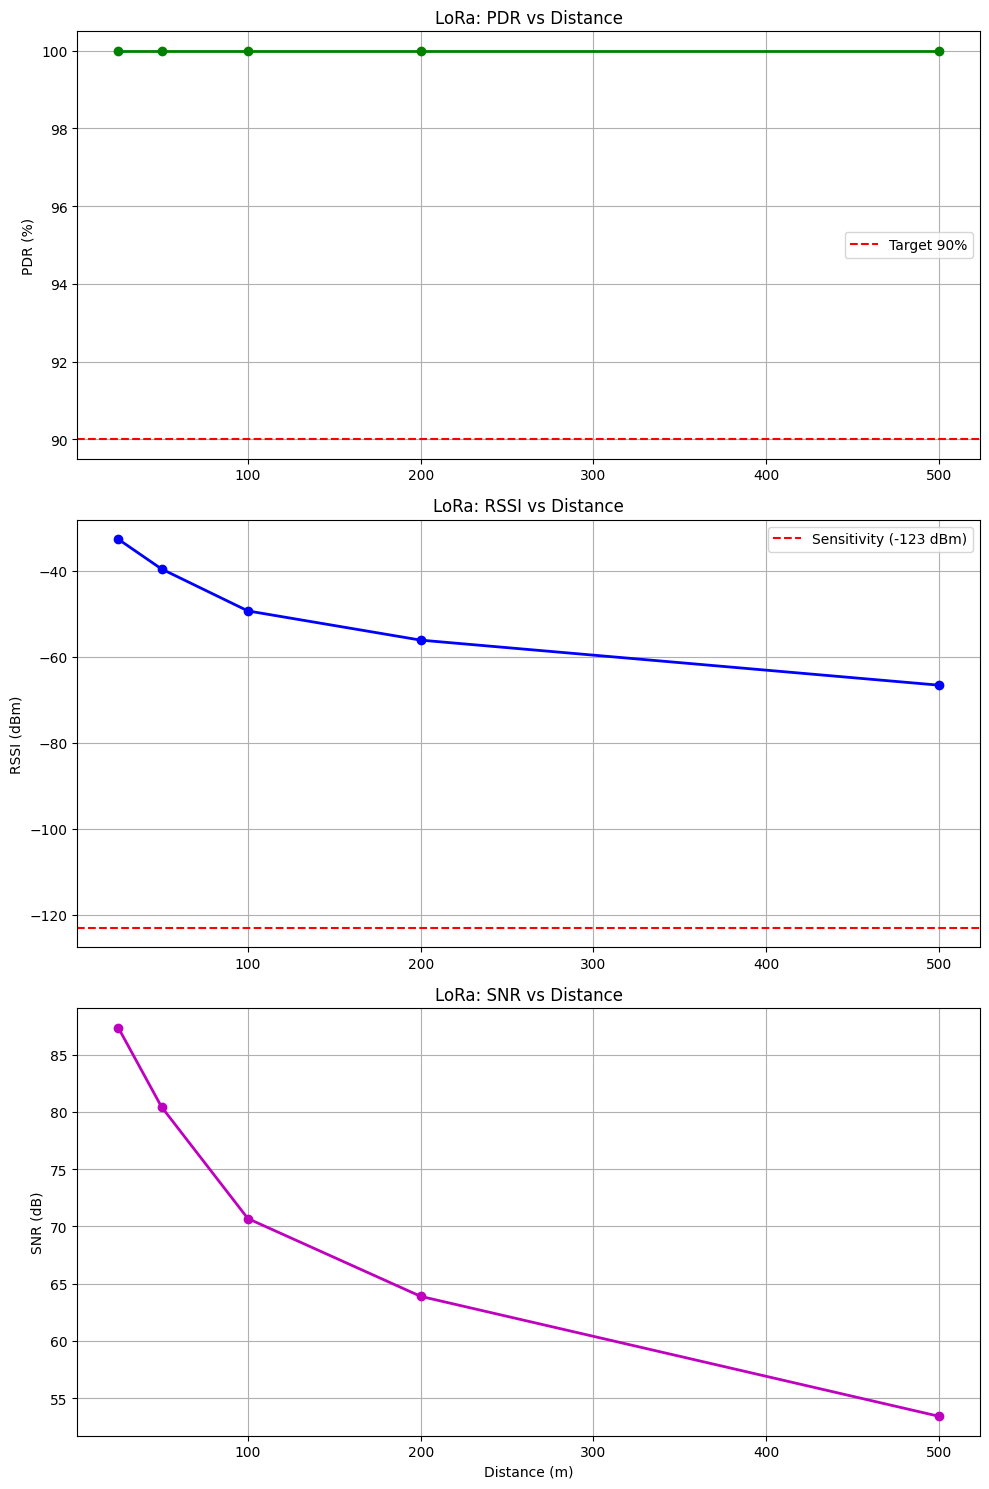

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# PDR vs Distance [cite: 77]
ax1.plot(lora_df['Distance'], lora_df['PDR'], 'g-o', linewidth=2)
ax1.axhline(y=90, color='r', linestyle='--', label="Target 90%")
ax1.set_title("LoRa: PDR vs Distance")
ax1.set_ylabel("PDR (%)")
ax1.grid(True)
ax1.legend()

# RSSI vs Distance [cite: 78]
ax2.plot(lora_df['Distance'], lora_df['RSSI_avg'], 'b-o', linewidth=2)
ax2.axhline(y=-123, color='r', linestyle='--', label="Sensitivity (-123 dBm)")
ax2.set_title("LoRa: RSSI vs Distance")
ax2.set_ylabel("RSSI (dBm)")
ax2.legend()
ax2.grid(True)

# SNR vs Distance [cite: 78]
ax3.plot(lora_df['Distance'], lora_df['Metric_avg'], 'm-o', linewidth=2)
ax3.set_title("LoRa: SNR vs Distance")
ax3.set_xlabel("Distance (m)")
ax3.set_ylabel("SNR (dB)")
ax3.grid(True)

plt.tight_layout()
plt.show()